In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=96267fd21e85c036494c9382ff2c3d41cddaac1140f8b7d6ecc088a6ddd45de7
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import wget

urls = [
    "https://engineering.case.edu/sites/default/files/99.mat",
    "https://engineering.case.edu/sites/default/files/107.mat"
]

wget.download(urls[0]) #99 as normal
wget.download(urls[1]) #107 as fault

'107.mat'

In [ ]:
import pandas as pd
import scipy.io as scio
import numpy as np

mat = scio.loadmat('99.mat')
variables = scio.whosmat('99.mat')

data1 = mat['X098_DE_time']
data2 = mat['X098_FE_time']

df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

normal=[]

for i in range(1000):
    a=np.concatenate([df1.values[i*200:200+i*200], df2.values[i*200:200+i*200]])
    a=np.reshape(a,(200,2))
    normal.append(a)


normal=np.squeeze(normal)
normal.shape

(1000, 200, 2)

In [ ]:
mat = scio.loadmat('107.mat')
variables = scio.whosmat('107.mat')

data1 = mat['X107_DE_time']
data2 = mat['X107_FE_time']

df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

f1=[]

for i in range(600):
    a=np.concatenate([df1.values[i*200:200+i*200], df2.values[i*200:200+i*200]])
    a=np.reshape(a,(200,2))
    f1.append(a)


f1=np.squeeze(f1)
f1.shape

(600, 200, 2)

In [ ]:
X = np.concatenate((normal, f1))
y = np.concatenate((np.zeros(len(normal)), np.ones(len(f1))))

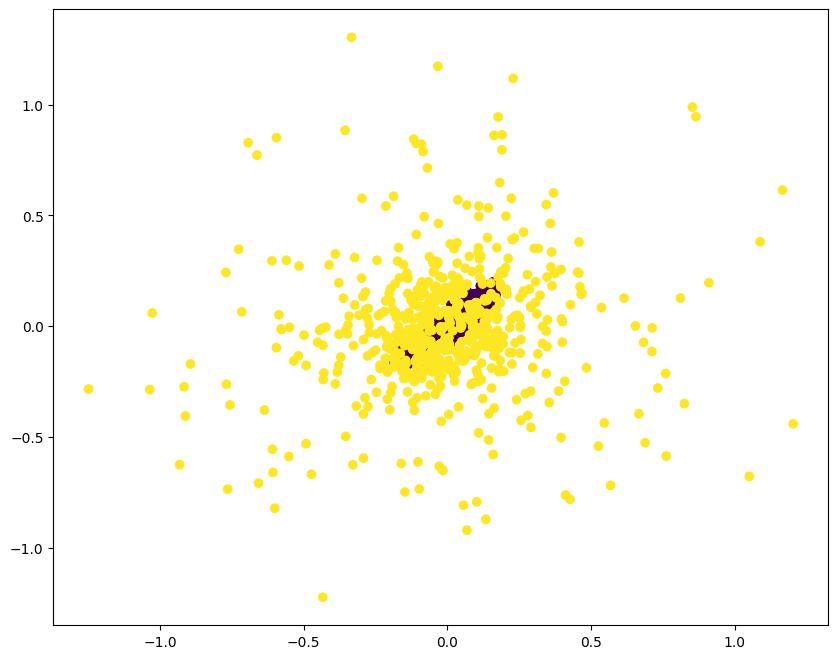

In [ ]:
import matplotlib.pyplot as plt
X_reshaped = X.reshape((1600, -1))

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()

ax.scatter(X_reshaped[:, 0], X_reshaped[:, 1],c=y)

# Extracting Features

In [ ]:
std_X= X.std(axis=1)
peak_X= X.max(axis=1)

from scipy.stats import skew, kurtosis
skewness_X= skew(X, axis=1)
kurtosis_X= kurtosis(X, axis=1)

crest_factor_X = np.max(X, axis=1) / np.sqrt(np.mean(X**2, axis=1))
ptp_X= np.ptp(X, axis=1)
mean_X= np.mean(X, axis=1)
rms_X = np.sqrt(np.mean(X**2, axis=1))
abs_mean_X= np.mean(np.abs(X), axis=1)

In [ ]:
X_new=np.concatenate([std_X, peak_X, skewness_X, kurtosis_X, crest_factor_X, ptp_X, mean_X, rms_X, abs_mean_X],axis=1)

In [ ]:
X_new.shape

(1600, 18)

In [ ]:
data= pd.DataFrame(X_new,columns=['std_0','std_1','peak_0','peak_1', 'skewness_0', 'skewness_1', 'kurtosis_0', 'kurtosis_1', 'crest_factor_0', 'crest_factor_1','ptp_0', 'ptp_1', 'mean_0', 'mean_1', 'rms_0', 'rms_1', 'abs_mean_0', 'abs_mean_1'])

In [ ]:
data.head()

,std_0,std_1,peak_0,peak_1,skewness_0,skewness_1,kurtosis_0,kurtosis_1,crest_factor_0,crest_factor_1,ptp_0,ptp_1,mean_0,mean_1,rms_0,rms_1,abs_mean_0,abs_mean_1
0,0.060663,0.060877,0.180800,0.171965,-0.365262,-0.337173,0.646471,0.463768,2.937679,2.785655,0.379610,0.362849,0.010385,0.010239,0.061545,0.061733,0.048017,0.048524
1,0.068410,0.068715,0.229082,0.206482,-0.059702,-0.102322,-0.008675,-0.046899,3.122650,2.798256,0.376573,0.366490,0.026496,0.026890,0.073361,0.073789,0.059287,0.059192
2,0.072933,0.072956,0.200318,0.213262,-0.098350,-0.092432,-0.316778,-0.261666,2.678186,2.853226,0.372217,0.388082,0.016593,0.016249,0.074796,0.074744,0.059930,0.059926
3,0.070353,0.070375,0.241204,0.223535,0.034709,-0.032924,0.196209,0.010201,3.166207,2.929587,0.438762,0.394808,0.029221,0.029486,0.076181,0.076302,0.060834,0.061052
4,0.058739,0.059006,0.185525,0.171349,-0.010071,0.030679,0.139992,0.065996,3.066759,2.823319,0.338232,0.320926,0.014474,0.014199,0.060496,0.060691,0.047044,0.047844


# Shuffling and Normalization

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.values, y, test_size=0.2, random_state=14) #shuffling is always true

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Manual classifier

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# The average logistic loss
def compute_loss(Y, Y_hat):
    Y = np.array(Y)
    Y_hat = np.array(Y_hat)
    epsilon = 1e-15
    # Clip probabilities to ensure they are in (0, 1) range
    Y_hat = np.clip(Y_hat, epsilon, 1 - epsilon)

    return -np.mean(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat))

def gradient_descent(X, Y, Y_hat, w, b, learning_rate):
    m = X.shape[0]
    dw = (1/m) * np.dot(X.T, (Y_hat - Y))
    db = (1/m) * np.sum(Y_hat - Y)
    w = w - learning_rate * dw
    b = b - learning_rate * db
    return w, b

def evaluate_model(Y, Y_hat):
    Y_pred = Y_hat > 0.5
    accuracy = np.mean(Y_pred == Y)
    precision = np.sum((Y_pred == 1) & (Y == 1)) / np.sum(Y_pred == 1)
    return accuracy, precision

Iteration 1: Loss 0.6931471805599453
Iteration 2: Loss 0.6847236183810892
Iteration 3: Loss 0.6764889694299887
Iteration 4: Loss 0.6684353656291779
Iteration 5: Loss 0.6605554367627237
Iteration 6: Loss 0.6528422799160143
Iteration 7: Loss 0.6452894294502746
Iteration 8: Loss 0.637890827819969
Iteration 9: Loss 0.630640797464064
Iteration 10: Loss 0.6235340139369361
Iteration 11: Loss 0.6165654803904159
Iteration 12: Loss 0.6097305034738625
Iteration 13: Loss 0.6030246706830575
Iteration 14: Loss 0.5964438291599761
Iteration 15: Loss 0.5899840659230348
Iteration 16: Loss 0.5836416894902798
Iteration 17: Loss 0.5774132128452794
Iteration 18: Loss 0.571295337686451
Iteration 19: Loss 0.5652849398945217
Iteration 20: Loss 0.5593790561491996
Iteration 21: Loss 0.5535748716244523
Iteration 22: Loss 0.5478697086916018
Iteration 23: Loss 0.5422610165604418
Iteration 24: Loss 0.5367463617904422
Iteration 25: Loss 0.5313234196066146
Iteration 26: Loss 0.5259899659575658
Iteration 27: Loss 0.520

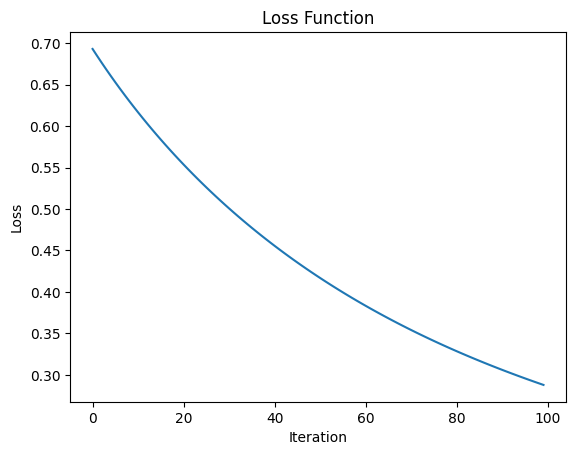

In [ ]:
# Model initialization
w = np.zeros((X_train_normalized.shape[1], 1))
b = 0
y_train = y_train.reshape(-1, 1)
learning_rate = 0.05
iterations = 100
losses = []


for i in range(iterations):
    Z = np.dot(X_train_normalized, w) + b
    Y_hat = sigmoid(Z)
    loss = compute_loss(y_train, Y_hat)
    w, b = gradient_descent(X_train_normalized, y_train, Y_hat, w, b, learning_rate)
    losses.append(loss)
    print(f"Iteration {i+1}: Loss {loss}")

y_test = y_test.reshape(-1, 1)
Z_test = np.dot(X_test_normalized, w) + b
Y_hat_test = sigmoid(Z_test)
accuracy, precision = evaluate_model(y_test, Y_hat_test)
print(f"\nTest Accuracy: {accuracy}, Test Precision: {precision}")

plt.plot(losses)
plt.title("Loss Function")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

# using SKLearn

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score

# Reshape to be 1-dimensional
y_train_ravel = y_train.ravel()
y_test_ravel = y_test.ravel()

model = SGDClassifier(loss='log_loss', max_iter=100 , learning_rate='constant', eta0=0.05)

model.fit(X_train_normalized, y_train_ravel)

y_pred_train = model.predict(X_train_normalized)
y_pred_test = model.predict(X_test_normalized)

# Evaluation
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
train_precision = precision_score(y_train, y_pred_train)
test_precision = precision_score(y_test, y_pred_test)

print(f"Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}")
print(f"Train Precision: {train_precision}, Test Precision: {test_precision}")

Train Accuracy: 1.0, Test Accuracy: 1.0
Train Precision: 1.0, Test Precision: 1.0


## With plotting

Train Accuracy: 1.0, Test Accuracy: 1.0
Train Precision: 1.0, Test Precision: 1.0


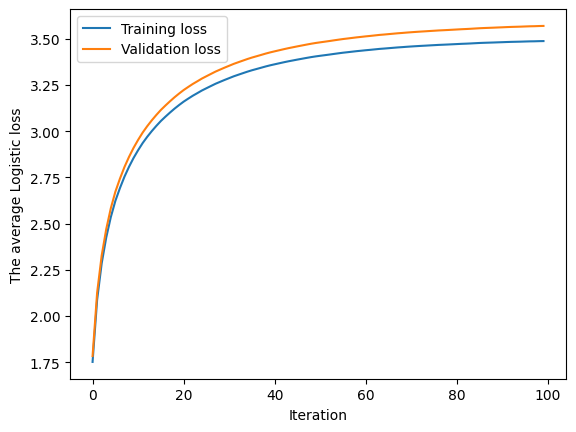

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score

model = SGDClassifier(loss='log_loss', max_iter=1 , learning_rate='constant', eta0=0.05)

# Reshape to be 1-dimensional
y_train_ravel = y_train.ravel()
y_test_ravel = y_test.ravel()

train_losses = []
val_losses = []

# Manual training loop
for _ in range(100):
    model.partial_fit(X_train_normalized, y_train_ravel, classes=np.unique(y))  # Partially fit the model

    # Calculate probabilities
    train_probs = model.predict_proba(X_train_normalized)[:, 1]
    val_probs = model.predict_proba(X_test_normalized)[:, 1]

    # Calculate and record the custom loss
    train_loss = compute_loss(y_train, train_probs)
    val_loss = compute_loss(y_test, val_probs)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

y_pred_train = model.predict(X_train_normalized)
y_pred_test = model.predict(X_test_normalized)

# Evaluation
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
train_precision = precision_score(y_train, y_pred_train)
test_precision = precision_score(y_test, y_pred_test)

print(f"Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}")
print(f"Train Precision: {train_precision}, Test Precision: {test_precision}")

# Plotting the loss curve
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Iteration')
plt.ylabel('The average Logistic loss')
plt.legend()
plt.show()